In [1]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
import string
import plotly.graph_objects as go
from itertools import count

In [2]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff']
plotted_models = ['DPN','ReXNet', 'EseVoVNet', 'TNT', 'Inception', 'HRNet', 'MobileNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_Magface', 'DPN_Cosface', 'SMAC']

## CelebA

In [3]:
import pandas as pd
import numpy as np
import os
from analysis import *
import glob
from functools import reduce

def reduce_list_rfw(l, f=max):
    sfx_cnt = count(1)
    df = reduce(lambda x, y: pd.merge(x, y, on = ['index','epoch'], suffixes=(f'_{next(sfx_cnt)}', '')), l)

    df['Metric'] = df.loc[:,df.columns.str.startswith('Metric')].apply(lambda x: f(x), axis=1)
    df=df.loc[:,np.logical_not(df.columns.str.startswith('Metric_'))]
    return df

def reduce_results(results, split, write=False):
    sfx_cnt = count(1)
    mean_acc = reduce(lambda x, y: pd.merge(x, y, on='index', suffixes=(f'_{next(sfx_cnt)}', '')),
                      [x['acc_df'] for x in results if x['split'] == split]).mean(axis=1)
    mean_rank = reduce(lambda x, y: pd.merge(x, y, on='index', suffixes=(f'_{next(sfx_cnt)}', '')),
                       [x['disp_df'] for x in results if x['split'] == split]).mean(axis=1)
    std_acc = reduce(lambda x, y: pd.merge(x, y, on='index', suffixes=(f'_{next(sfx_cnt)}', '')),
                     [x['acc_df'] for x in results if x['split'] == split]).sem(axis=1)
    std_rank = reduce(lambda x, y: pd.merge(x, y, on='index', suffixes=(f'_{next(sfx_cnt)}', '')),
                      [x['disp_df'] for x in results if x['split'] == split]).sem(axis=1)

    df = pd.DataFrame(columns = ['Accuracy_mean', 'Accuracy_std', 'Disparity_mean', 'Disparity_std'])
    df['Accuracy_mean'] = mean_acc
    df['Disparity_mean'] = mean_rank
    df['Accuracy_std'] = std_acc
    df['Disparity_std'] = std_rank
    df['Model'] = [x[:x.find('Face')-4] if 'dpn' not in x else x[:x.find('Face')+4].replace('dpn107','DPN') for x in df.index]
    if write:
        df.to_csv(f'vggface_phase1_{split}.csv')
    return df

In [21]:
def make_tables(metric_function_output, **args):
    results = []
    for split in ['test']:
        for seed in [333,444,555,666]:
            acc_list_rfw, disp_list_rfw = [],[]
            rank_files = glob.glob(f'RFW_celeba/**_{seed}/**/*{split}*.pkl')
            for a in ['AfAs', 'AfCa', 'AfIn', 'AsCa', 'AsIn', 'CaIn']:
                metadata = pd.read_csv(f'RFW_{a}_{split}_identities_ethnicity.csv')

                epochs = ['epoch_'+str(i) for i in [101]]
                acc_df_vgg, _, _ = analyze_pickle_files([[x] for x in rank_files], metadata, epochs=epochs)
                disp_df = analyze_pickle_files([[x] for x in rank_files], metadata, epochs=epochs, **args)[metric_function_output]
                acc_df_vgg['Metric'] = 1 - acc_df_vgg['Metric']
                
                acc_list_rfw += [acc_df_vgg]
                disp_list_rfw += [disp_df]

            acc_df_rfw = reduce_list_rfw(acc_list_rfw, f=np.mean)
            disp_df_rfw = reduce_list_rfw(disp_list_rfw)
                
            res = {
                'split': split,
                'seed': seed,
                'acc_df': acc_df_rfw[['index','Metric']].set_index('index'),
                'disp_df': disp_df_rfw[['index','Metric']].set_index('index')
                  }
            results += [res]
    df_val = None
    df_test = reduce_results(results, 'test')
    return df_val, df_test

In [5]:
def plot_figure(metric_name, metric_suffix, split, df):
    fig = px.scatter(df, 
                     x='Accuracy_mean', 
                     y='Disparity_mean', 
                     error_x = "Accuracy_std", 
                     error_y = "Disparity_std", 
                     color="Model", 
                     color_discrete_map=color_map,
                     template="simple_white",
                     width=1200, height= 1000
                    )
#     if metric_name == 'Rank Disparity':
#         fig.update_layout(
#             xaxis_range=[0,0.15],
#             yaxis_range=[-.01,.6]
#         )
    fig.update_layout(
        xaxis_title="Error",
        yaxis_title=metric_name,
        title="Trained on CelebA; Tested on RFW",
        legend_title="Models",
        font=dict(
            family="Times New Roman",
            size=30,
            color="Black"
        )
    )
    fig.update_traces(marker=dict(size=20))
#     fig.update_layout(legend=dict(
#         orientation="h",
#         yanchor="bottom",
#         y=1.02,
#         xanchor="right",
#         x=1,
#         font=dict(
#             family="Times New Roman",
#             size=28,
#             color="Black"
#         )
#     ))
    p = np.array(preparePareto(df[['Accuracy_mean','Disparity_mean']], False, False).dropna())
    for x, y in zip(p[:-1], p[1:]):
        fig.add_shape(type='line',
                    x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                    line=dict(color='gray',width=4),line_dash='dash',
                    xref='x',yref='y')
#     plotly.io.write_image(fig, f'_RQ2_{split}_vgg_{metric_suffix}.png', format='png')
    fig.show()

In [6]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff', '#42d4f4']
plotted_models = ['DPN','ReXNet', 'Other', 'TNT', 'Inception', 'HRNet', 'EseVoVNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_MagFace', 'DPN_CosFace', 'SMAC', 'Swin_Transformer']
color_map = {}
for c,m in zip(colors,plotted_models):
    color_map[m] = c

In [23]:
# def phase2(metric_name, metric_suffix, metric_function_output, plot=False, **args):
#     lookup = {
#         'Checkpoints_Edges_301_LR_0.13828312564892567_Head': 'SMAC',
#         'Checkpoints_Edges_600_LR_0.6708884458871945_Head': 'SMAC',
#         'Checkpoints_Edges_248_LR_0.09532880096168164_Head': 'SMAC',
#         'Checkpoints_Edges_258_LR_0.1404172769842098_Head': 'SMAC',
#         'Checkpoints_Edges_680_LR_0.0006048015915653069_Head': 'SMAC',
#         'Checkpoints_Edges_010_LR_0.32348738788346576_Head': 'SMAC',
#         'Checkpoints_Edges_000_LR_0.2813375341651194_Head': 'SMAC',
#         'coat_lite_small': 'Other',
#         'convit_base': 'Other',
#         'cspdarknet53': 'Other',
#         'densenet161': 'DenseNet',
#         'dla102x2': 'Other',
#         'DPN_ArcFace': 'Other',
#         'DPN_MagFace': 'DPN_MagFace',
#         'DPN_CosFace': 'DPN_CosFace',
#         'ese_vovnet39b': 'EseVoVNet',
#         'hrnet_w64': 'HRNet',
#         'jx_nest_base': 'Other',
#         'mobilenetv3_large_100': 'Other',
#         'rexnet_200': 'ReXNet',
#         'swin_base_patch4_window7_224': 'Swin_Transformer',
#         'tf_efficientnet_b7_ns': 'Other',
#         'tnt_s_patch16_224': 'TNT',
#         'twins_svt_large': 'Other'
#     }
    
#     df_val, df_test = make_tables(metric_function_output, **args)
#     # df_val['Model'] = df_val['Model'].apply(lambda l: lookup[l])
#     df_test['Model'] = df_test['Model'].apply(lambda l: lookup[l])
#     if plot:
#         # plot_figure(metric_name, metric_suffix, 'val', df_val)
#         plot_figure(metric_name, metric_suffix, 'test', df_test)   
#     return df_val, df_test

In [24]:
# df_val_rd, df_test_rd = phase2('Rank Disparity', '', 2, plot=False)
# df_val_d, df_test_d   = phase2('Disparity','disparity', 1, plot=False)
# df_val_rr, df_test_rr = phase2('Rank Ratio', 'rank_ratio', 2, ratio=True, plot=False)
# df_val_r, df_test_r   = phase2('Ratio', 'ratio', 1, ratio=True, plot=False)
# df_val_er, df_test_er = phase2('Error Ratio', 'error_ratio', 1, ratio=True, error=True, plot=False)

In [30]:
# celeba = df_test_rd.merge(df_test_d, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
# celeba = celeba.rename(columns={"Disparity_mean_x": "Rank Disparity_mean", "Disparity_std_x": "Rank Disparity_std"})
# celeba = celeba.rename(columns={"Disparity_mean_y": "Disparity_mean", "Disparity_std_y": "Disparity_std"})
# celeba = celeba.merge(df_test_rr, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
# celeba = celeba.rename(columns={"Disparity_mean_x": "Disparity_mean", "Disparity_std_x": "Disparity_std"})
# celeba = celeba.rename(columns={"Disparity_mean_y": "Rank Ratio_mean", "Disparity_std_y": "Rank Ratio_std"})
# celeba = celeba.merge(df_test_r, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
# celeba = celeba.rename(columns={"Disparity_mean_x": "Disparity_mean", "Disparity_std_x": "Disparity_std"})
# celeba = celeba.rename(columns={"Disparity_mean_y": "Ratio_mean", "Disparity_std_y": "Ratio_std"})
# celeba = celeba.merge(df_test_er, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
# celeba = celeba.rename(columns={"Disparity_mean_x": "Disparity_mean", "Disparity_std_x": "Disparity_std"})
# celeba = celeba.rename(columns={"Disparity_mean_y": "Error Ratio_mean", "Disparity_std_y": "Error Ratio_std"})
# celeba = celeba.rename(columns={"Accuracy_mean": "Error_mean", "Accuracy_std": "Error_std"})
# celeba.to_csv("celeba_transfer_rfw_test.csv")

In [28]:
def plot_figure(metric_name, metric_suffix, split, df):
    fig = px.scatter(df, 
                     x='Error_mean', 
                     y=f'{metric_name}_mean', 
                     error_x = "Error_std", 
                     error_y = f"{metric_name}_std", 
                     color="Model", 
                     color_discrete_map=color_map,
                     template="simple_white",
                     width=1200, height= 1000
                    )
    fig.update_layout(
        xaxis_title="Error",
        yaxis_title=metric_name,
        title="Trained on CelebA; Tested on RFW",
        legend_title="Models",
        font=dict(
            family="Times New Roman",
            size=30,
            color="Black"
        )
    )
    fig.update_traces(marker=dict(size=20))
    p = np.array(preparePareto(df[['Error_mean',f'{metric_name}_mean']], False, False).dropna())
    for x, y in zip(p[:-1], p[1:]):
        fig.add_shape(type='line',
                    x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                    line=dict(color='gray',width=4),line_dash='dash',
                    xref='x',yref='y')
#     plotly.io.write_image(fig, f'_RQ2_{split}_vgg_{metric_suffix}.png', format='png')
    fig.show()

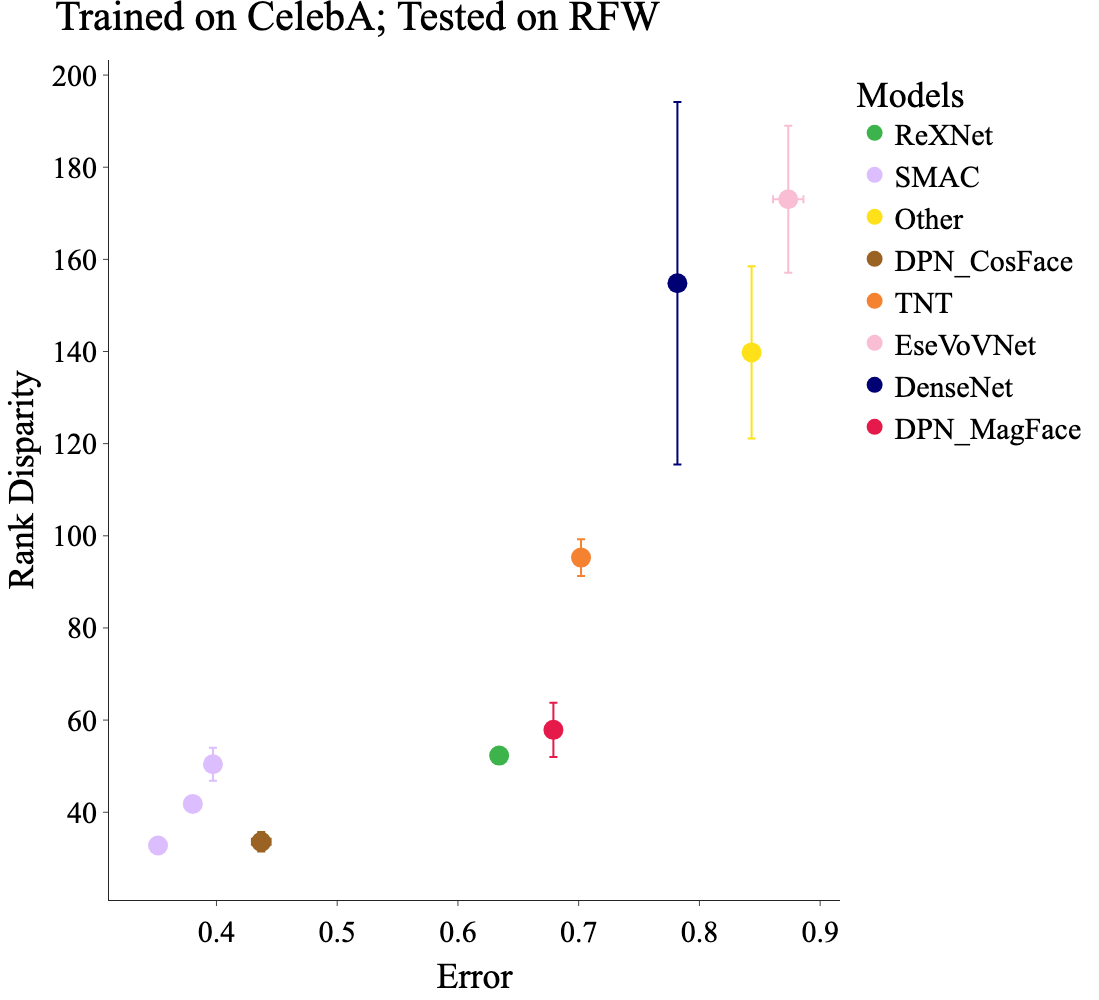

In [29]:
plot_figure('Rank Disparity', '', 'test', celeba)

## VGGFace2

In [31]:
def make_tables(metric_function_output, **args):
    results = []
    for split in ['test']:
        metadata = pd.read_csv(f'vggface2_{split}_identities_gender.csv')
        for seed in [111,222,333]:
            acc_list_rfw, disp_list_rfw = [],[]
            rank_files = glob.glob(f'RFW_vggface2/**_{seed}/**/*11_test.pkl')
            for a in ['AfAs', 'AfCa', 'AfIn', 'AsCa', 'AsIn', 'CaIn']:
                metadata = pd.read_csv(f'RFW_{a}_test_identities_ethnicity.csv')

                epochs = ['epoch_'+str(i) for i in [11]]
                acc_df_vgg, _, _ = analyze_pickle_files([[x] for x in rank_files], metadata, epochs=epochs)
                disp_df = analyze_pickle_files([[x] for x in rank_files], metadata, epochs=epochs, **args)[metric_function_output]
                acc_df_vgg['Metric'] = 1 - acc_df_vgg['Metric']
                
                acc_list_rfw += [acc_df_vgg]
                disp_list_rfw += [disp_df]

            acc_df_rfw = reduce_list_rfw(acc_list_rfw, f=np.mean)
            disp_df_rfw = reduce_list_rfw(disp_list_rfw)
                
            res = {
                'split': split,
                'seed': seed,
                'acc_df': acc_df_rfw[['index','Metric']].set_index('index'),
                'disp_df': disp_df_rfw[['index','Metric']].set_index('index')
                  }
            results += [res]
    df_val = None #reduce_results(results, 'val')
    df_test = reduce_results(results, 'test')
    return df_val, df_test

In [32]:
def plot_figure(metric_name, metric_suffix, split, df):
    fig = px.scatter(df, 
                     x='Accuracy_mean', 
                     y='Disparity_mean', 
                     error_x = "Accuracy_std", 
                     error_y = "Disparity_std", 
                     color="Model", 
                     color_discrete_map=color_map,
                     template="simple_white",
                     width=1200, height= 1000
                    )
#     if metric_name == 'Rank Disparity':
#         fig.update_layout(
#             xaxis_range=[0,0.15],
#             yaxis_range=[-.01,.6]
#         )
    fig.update_layout(
        xaxis_title="Error",
        yaxis_title=metric_name,
        title="Trained on VGGFace2; Tested on RFW",
        legend_title="Models",
        font=dict(
            family="Times New Roman",
            size=30,
            color="Black"
        )
    )
    fig.update_traces(marker=dict(size=20))
#     fig.update_layout(legend=dict(
#         orientation="h",
#         yanchor="bottom",
#         y=1.02,
#         xanchor="right",
#         x=1,
#         font=dict(
#             family="Times New Roman",
#             size=28,
#             color="Black"
#         )
#     ))
    p = np.array(preparePareto(df[['Accuracy_mean','Disparity_mean']], False, False).dropna())
    for x, y in zip(p[:-1], p[1:]):
        fig.add_shape(type='line',
                    x0=x[0],y0=x[1],x1=y[0],y1=y[1],
                    line=dict(color='gray',width=4),line_dash='dash',
                    xref='x',yref='y')
#     plotly.io.write_image(fig, f'_RQ2_{split}_vgg_{metric_suffix}.png', format='png')
    fig.show()

In [33]:
colors = ['#e6194B', '#3cb44b', '#ffe119','#f58231','#42d4f4',
          '#f032e6','#fabed4','#469990','#aaffc3','#000075','#e6194B','#9a6324','#dcbeff', '#42d4f4']
plotted_models = ['DPN','ReXNet', 'Other', 'TNT', 'Inception', 'HRNet', 'EseVoVNet', 'VGG19', 'ResNet-RS', 
                 'DenseNet', 'DPN_MagFace', 'DPN_CosFace', 'SMAC', 'Swin_Transformer']
color_map = {}
for c,m in zip(colors,plotted_models):
    color_map[m] = c

In [36]:
def phase2(metric_name, metric_suffix, metric_function_output, plot=False, **args):
    lookup = {
        'Checkpoints_Edges_301_LR_0.13828312564892567_Head': 'SMAC',
        'Checkpoints_Edges_600_LR_0.6708884458871945_Head': 'SMAC',
        'Checkpoints_Edges_248_LR_0.09532880096168164_Head': 'SMAC',
        'Checkpoints_Edges_258_LR_0.1404172769842098_Head': 'SMAC',
        'coat_lite_small': 'Other',
        'convit_base': 'Other',
        'cspdarknet53': 'Other',
        'dla102x2': 'Other',
        'DPN_ArcFace': 'Other',
        'DPN_MagFace': 'DPN_MagFace',
        'DPN_CosFace': 'DPN_CosFace',
        'ese_vovnet39b': 'EseVoVNet',
        'hrnet_w64': 'HRNet',
        'jx_nest_base': 'Other',
        'rexnet_200': 'ReXNet',
        'swin_base_patch4_window7_224': 'Swin_Transformer',
        'tf_efficientnet_b7_ns': 'Other',
        'tnt_s_patch16_224': 'TNT',
        'twins_svt_large': 'Other'
    }
    
    df_val, df_test = make_tables(metric_function_output, **args)
    # df_val['Model'] = df_val['Model'].apply(lambda l: lookup[l])
    df_test['Model'] = df_test['Model'].apply(lambda l: lookup[l])
    if plot:
        # plot_figure(metric_name, metric_suffix, 'val', df_val)
        plot_figure(metric_name, metric_suffix, 'test', df_test)   
    return df_val, df_test

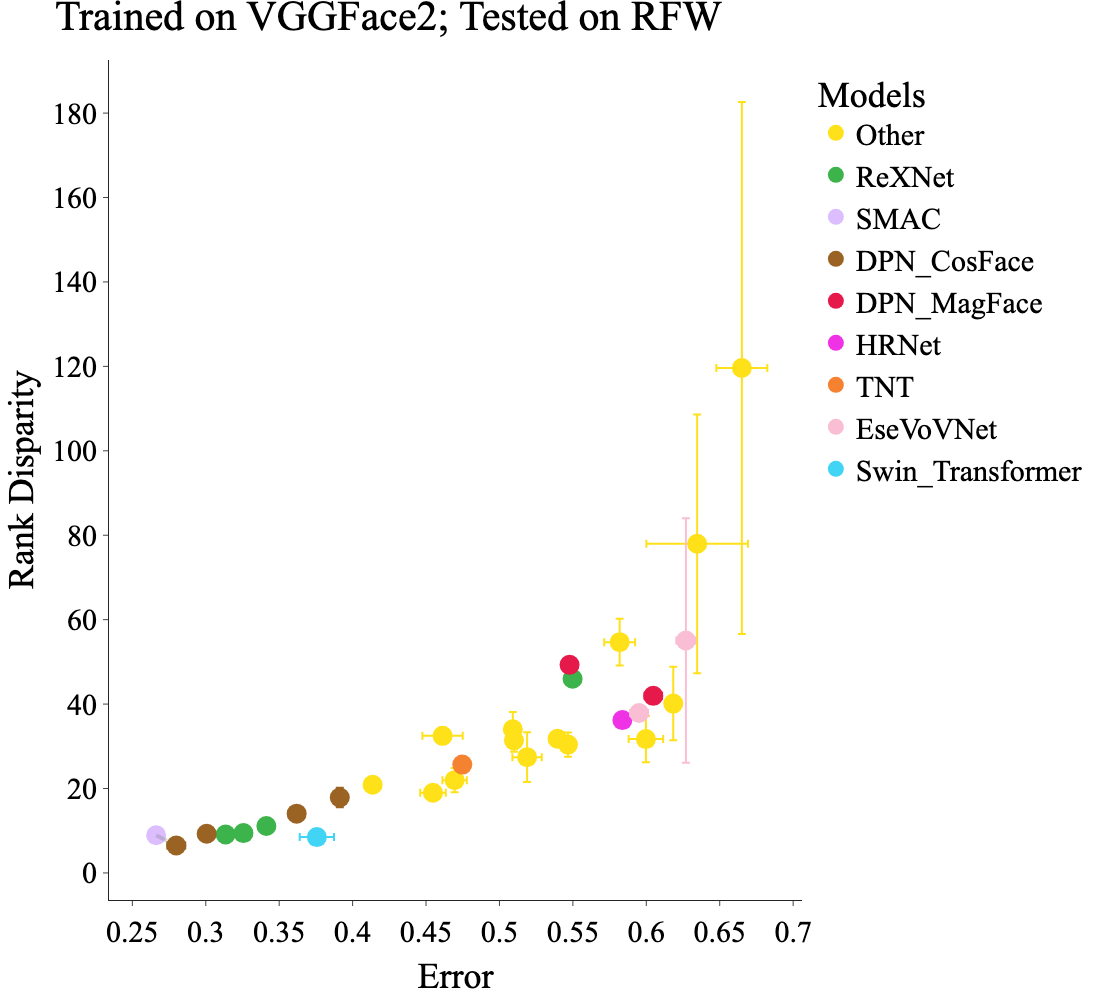

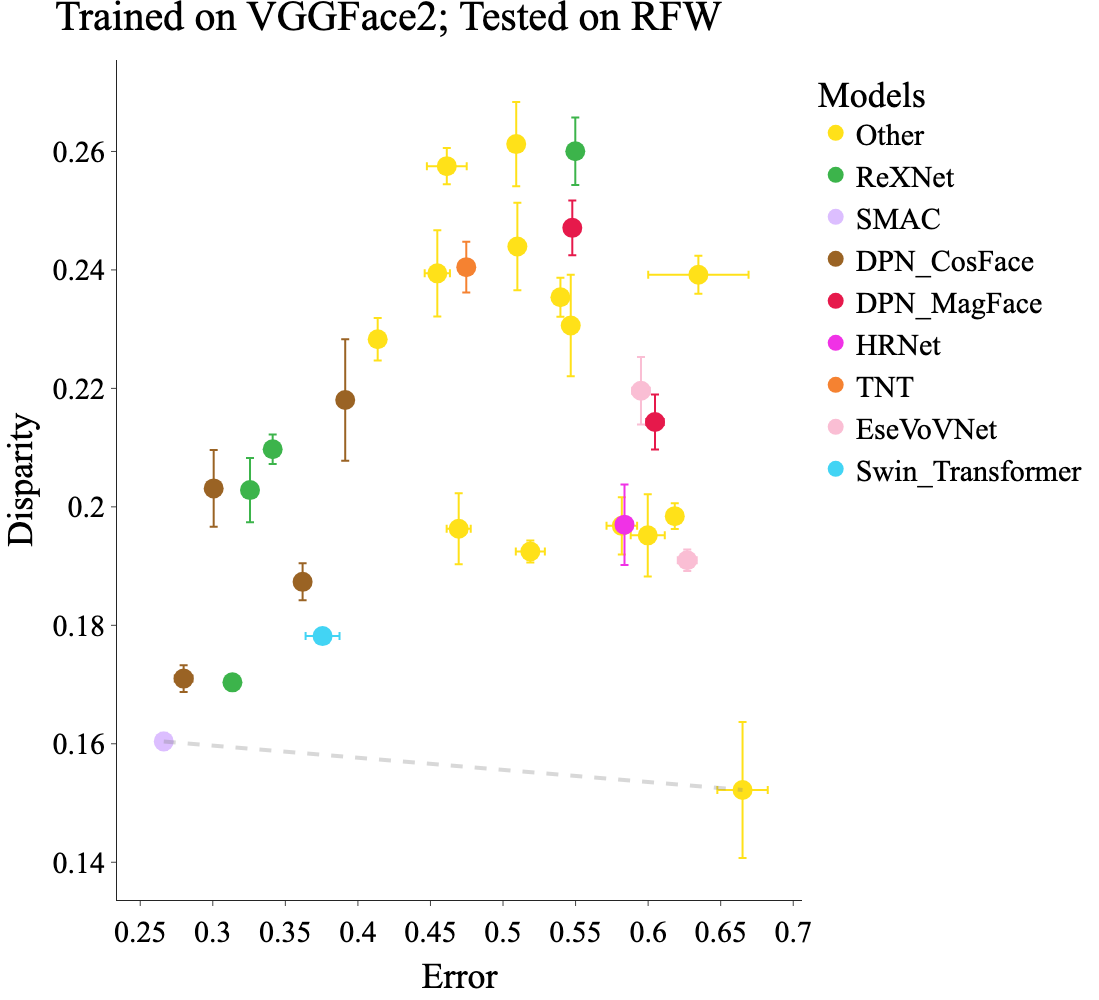

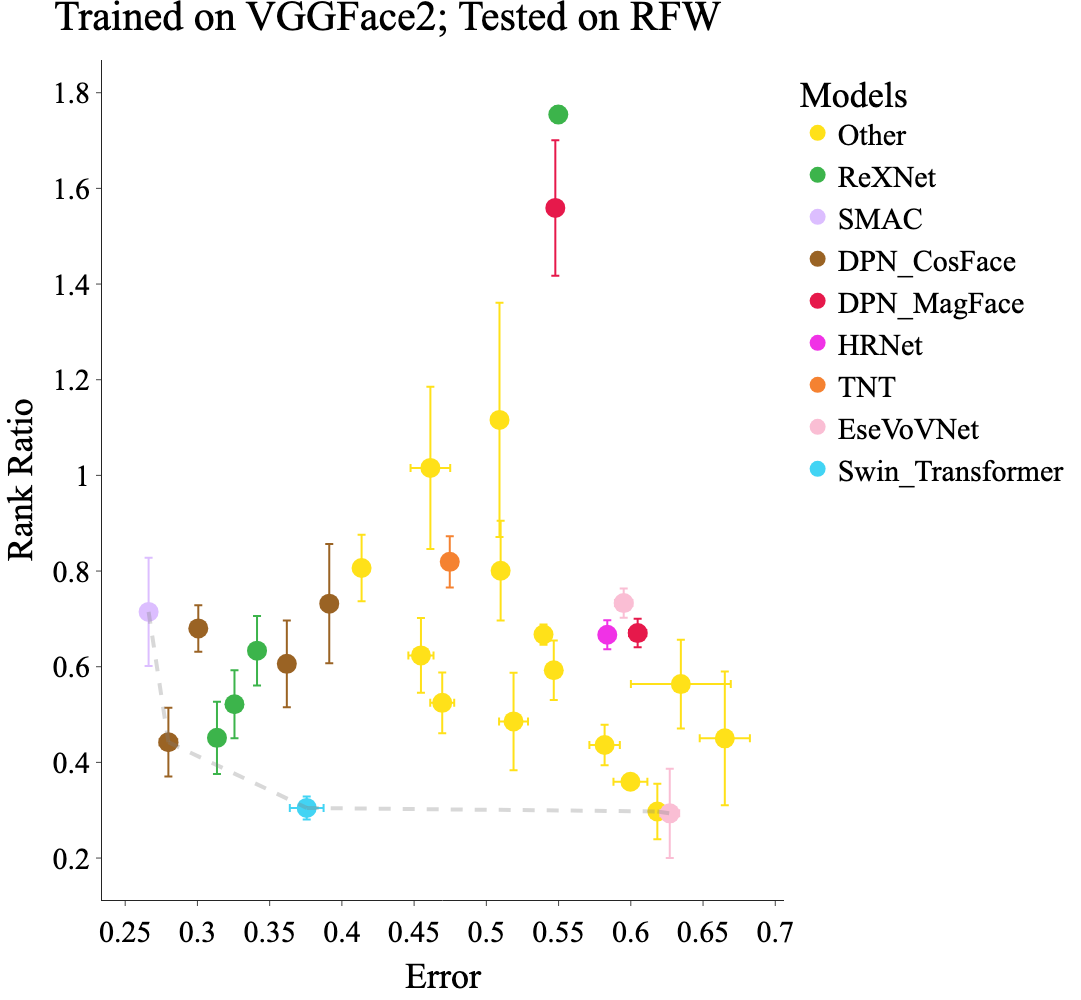

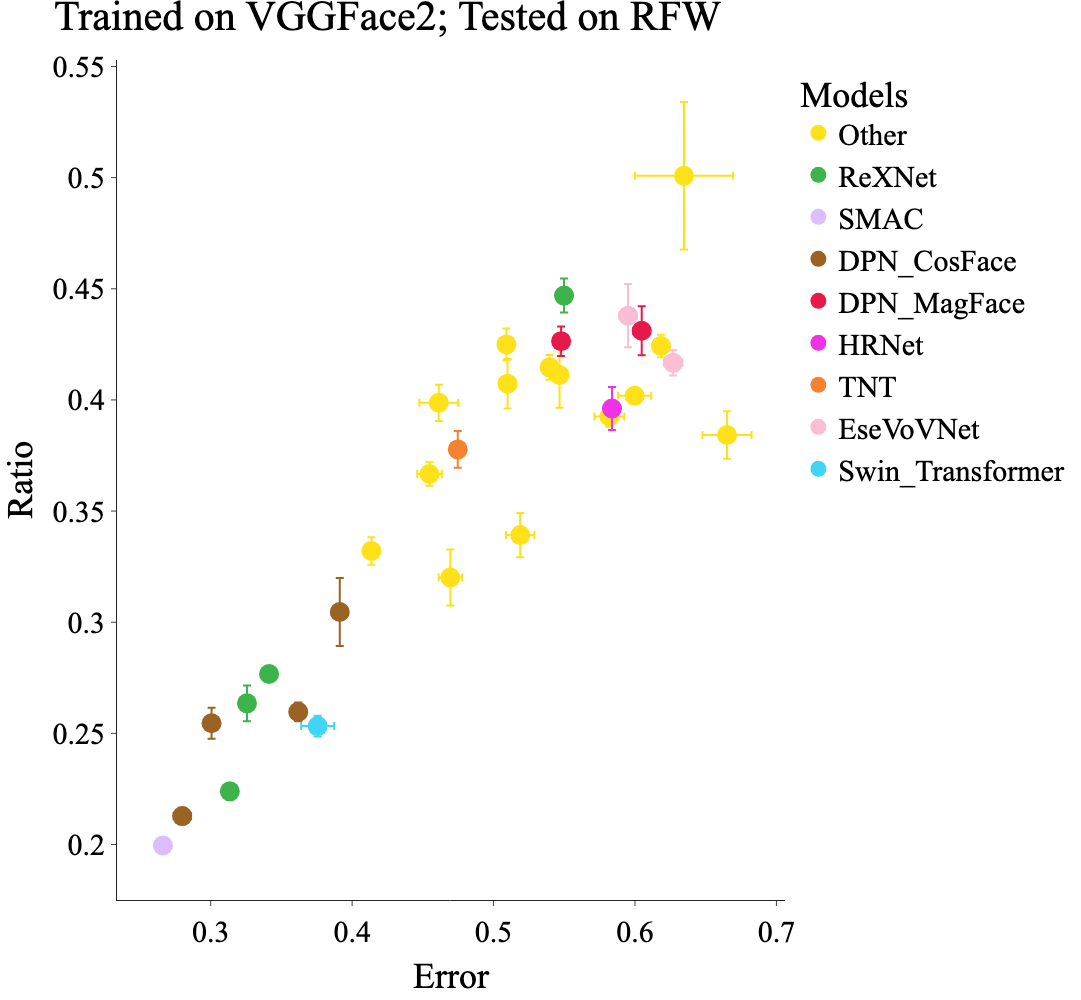

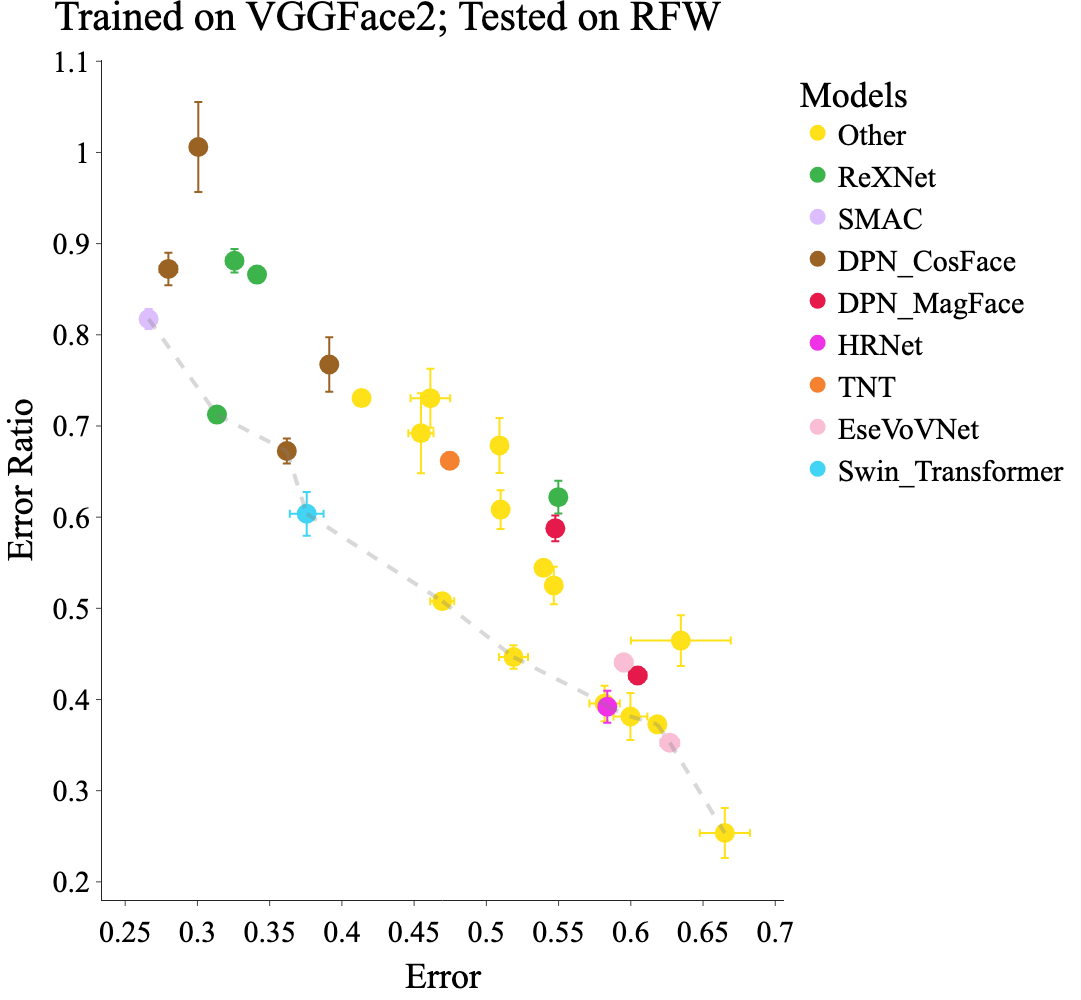

In [38]:
df_val, df_test_rd = phase2('Rank Disparity', '', 2, plot=True)
df_val, df_test_d  = phase2('Disparity','disparity', 1, plot=True)
df_val, df_test_rr = phase2('Rank Ratio', 'rank_ratio', 2, ratio=True, plot=True)
df_val, df_test_r  = phase2('Ratio', 'ratio', 1, ratio=True, plot=True)
df_val, df_test_er = phase2('Error Ratio', 'error_ratio', 1, ratio=True, error=True, plot=True)

In [39]:
vgg = df_test_rd.merge(df_test_d, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
vgg = vgg.rename(columns={"Disparity_mean_x": "Rank Disparity_mean", "Disparity_std_x": "Rank Disparity_std"})
vgg = vgg.rename(columns={"Disparity_mean_y": "Disparity_mean", "Disparity_std_y": "Disparity_std"})
vgg = vgg.merge(df_test_rr, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
vgg = vgg.rename(columns={"Disparity_mean_x": "Disparity_mean", "Disparity_std_x": "Disparity_std"})
vgg = vgg.rename(columns={"Disparity_mean_y": "Rank Ratio_mean", "Disparity_std_y": "Rank Ratio_std"})
vgg = vgg.merge(df_test_r, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
vgg = vgg.rename(columns={"Disparity_mean_x": "Disparity_mean", "Disparity_std_x": "Disparity_std"})
vgg = vgg.rename(columns={"Disparity_mean_y": "Ratio_mean", "Disparity_std_y": "Ratio_std"})
vgg = vgg.merge(df_test_er, on=['index', 'Model', 'Accuracy_mean', 'Accuracy_std'])
vgg = vgg.rename(columns={"Disparity_mean_x": "Disparity_mean", "Disparity_std_x": "Disparity_std"})
vgg = vgg.rename(columns={"Disparity_mean_y": "Error Ratio_mean", "Disparity_std_y": "Error Ratio_std"})
vgg = vgg.rename(columns={"Accuracy_mean": "Error_mean", "Accuracy_std": "Error_std"})
vgg.to_csv("vgg_transfer_rfw_test.csv")